In [154]:
#construct 4-bit landscape
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# read input & collect all info into a dictionary
file = '../data/nk-landscape-N4.tsv'
df = pd.read_csv(file, delimiter="\t", dtype={'hap':str}) # hap column as strings (otherwise read as numbers)
print(df.head())
plt.figure()
#df['fit'].plot.hist(bins=10)
recs = df.to_dict("records")
dHap = {}
for rec in recs:
    dHap[rec['hap']] = {'id': rec['ranked_id'], 'fit': rec['fit']}
print(dHap)

  ranked_id   hap       fit model  N_max       r/s
0      H000  0100  1.000000    nk      2  1.100008
1      H001  0110  0.935980    nk      2  1.100008
2      H002  0010  0.928026    nk      2  1.100008
3      H003  0000  0.767585    nk      2  1.100008
4      H004  0101  0.715364    nk      2  1.100008
{'0100': {'id': 'H000', 'fit': 1.0}, '0110': {'id': 'H001', 'fit': 0.935980365246103}, '0010': {'id': 'H002', 'fit': 0.9280264708193288}, '0000': {'id': 'H003', 'fit': 0.7675846272820299}, '0101': {'id': 'H004', 'fit': 0.7153636997011478}, '0111': {'id': 'H005', 'fit': 0.6513440649472507}, '1010': {'id': 'H006', 'fit': 0.6137841321244767}, '1100': {'id': 'H007', 'fit': 0.5540037196748708}, '1110': {'id': 'H008', 'fit': 0.4899840849209735}, '0011': {'id': 'H009', 'fit': 0.4746841822321512}, '1000': {'id': 'H010', 'fit': 0.4533422885871776}, '0001': {'id': 'H011', 'fit': 0.3142423386948521}, '1101': {'id': 'H012', 'fit': 0.2693674193760186}, '1111': {'id': 'H013', 'fit': 0.20534778462212

<Figure size 432x288 with 0 Axes>

In [155]:
# build graph, add nodes & attach fitness as features
DG = nx.DiGraph() 
for hap in dHap: # hap as key
    DG.add_node(hap)
    for k in dHap[hap]: # k includes 'id' and 'fit'
        DG.nodes[hap][k] = dHap[id][k]
print(DG)

DiGraph with 16 nodes and 0 edges


In [156]:
# Test case: add edges recursively
# The total number of unique binary haps of length n is the sum of binomial coefficients
# which evaluates to 2^n (https://mathworld.wolfram.com/BinomialSums.html)
# The total number of 1-bit edges is: n2^2 - n*2^(n-1) = n* 2^(n-1)
def add_edge_test(G, hap, outList, k, seen):
    num_zeros = len([x for x in hap if x == '0'])
    if num_zeros == 0: # reached the end hap (all 1's)
        seen[hap] = 1
        return
    if hap in seen_nodes: # node already reached
        return
    else: # contains at least one zero & not seen
        seen[hap] = 1
        nabes = {'level':k, 'hap_list': []} # start a list
        for i in range(len(hap)): # mutate each 0 to 1
            if hap[i] == '0':
                mut = hap[0:i] + '1' + hap[(i+1):]
                nabes['hap_list'].append(mut)
        outList.append(nabes) # append hap list to output list
        k += 1 # next level
        for x in nabes['hap_list']: # recurse on each child node
            if x not in seen: # skip if seen
                add_edge_test(G, x, outList, k, seen)

out = []
seen_nodes = {}
add_edge_test(DG, '0000', out, 1, seen_nodes) # start recursion at '0000'
levels = np.unique(np.array([x['level'] for x in out]))
for lev in levels:
    flat = []
    hap = [x['hap_list'] for x in out if x['level'] == lev]
    for h in hap:
        flat.append(h)
    print(lev, ":", np.unique(np.array(flat)))
#print(out)
#for x in out:
#    print(x)   

1 : ['0001' '0010' '0100' '1000']
2 : ['0011' '0101' '0110' '1001' '1010' '1100']
3 : ['0111' '1011' '1101' '1110']
4 : ['1111']


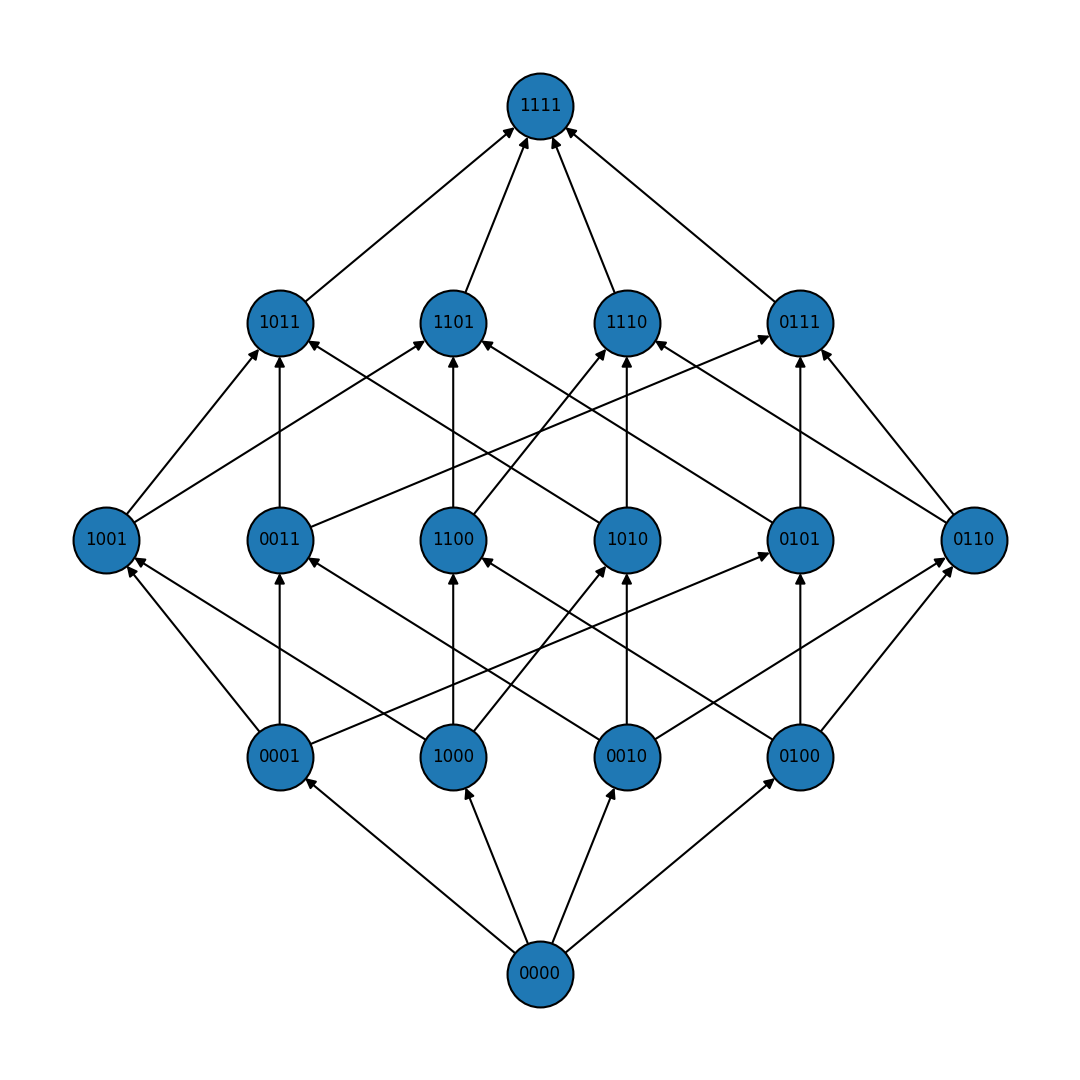

In [157]:
# now add edges & assign layers
# layout and draw Gallary:https://networkx.org/documentation/stable/auto_examples/index.html
def add_fit_edge(G, hap, seen, level):
    num_zeros = len([x for x in hap if x == '0'])
    if num_zeros == 0: # reached the end hap (all 1's)
        seen[hap] = 1
        return
    if hap in seen_nodes: # node already reached
        return
    else: # contains at least one zero & not seen
        seen[hap] = 1
        G.nodes[hap]['subset'] = level
        nabes = [] # start a list
        for i in range(len(hap)): # mutate each 0 to 1
            if hap[i] == '0':
                mut = hap[0:i] + '1' + hap[(i+1):]
                if G.nodes[hap]['fit'] > G.nodes[mut]['fit']:
                    G.add_edge(mut, hap)
                else:
                    G.add_edge(hap, mut)
                nabes.append(mut)
        level += 1
        for x in nabes: # recurse on each child node
            if x not in seen: # skip if seen
                G.nodes[x]['subset'] = level
                add_fit_edge(G, x, seen, level)
seen_nodes = {}
add_fit_edge(DG, '0000', seen_nodes, 0)
#print(DG.nodes())
#print(len(DG.edges()))

# node coloring by fitness 
#node_colors = range(10)
node_alphas = [ DG.nodes[x]['fit'] for x in DG.nodes]
#print(node_alphas)

# multi-partite layout, subset by num of 0's
pos = nx.multipartite_layout(DG, align = 'horizontal')
plt.figure(figsize = (7,7), dpi=150)
nx.draw(DG, pos = pos,
        with_labels = True, 
        node_size = 1000,
#        alpha = node_alphas, didn't work
        edgecolors = "black",
#        node_color = ['orange'] * 5 + ['lightgray'] * 10,
#        edgecolors = ['red'] * 5 + ['black'] * 10,
        font_size = 8)
#plt.show()
plt.savefig("graph.png")
#print(DG.adj[strains[0]])

array([<AxesSubplot:title={'center':'in_deg'}, xlabel='hap'>,
       <AxesSubplot:title={'center':'out_deg'}, xlabel='hap'>],
      dtype=object)

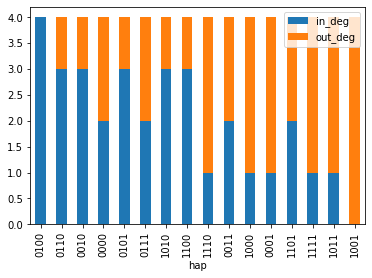

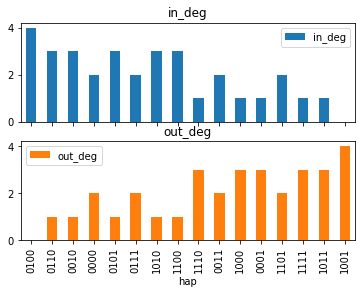

In [153]:
# degree analysis: fitness peak has only in_degrees and no out_degrees
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html
#print(DG.in_degree()) # in-degree
#print(DG.out_degree()) # in-degree
in_deg = [x[1] for x in DG.in_degree()]
out_deg = [x[1] for x in DG.out_degree()]
haps = [x[0] for x in DG.in_degree()]
#print(in_deg)
#print(out_deg)
#print(haps)
dfDeg = pd.DataFrame({'hap': haps, 'in_deg': in_deg, 'out_deg':out_deg})
#print(dfDeg.head())
dfDeg.plot.bar(x = 'hap', stacked = True)
dfDeg.plot.bar(x = 'hap', subplots = True)

#print(dfDeg.head())